In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn
import numpy as np
from glob import glob
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

import string
from os import listdir
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from pickle import dump
from string import punctuation

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NLP Project/Dataset/Multi_labeled_toxic_comments.csv')

df.head()

text  vulgar  hate  religious  \
0  প্রধানমন্ত্রী হক সাহেবের ক্ষতি হলে জাতির স্বার...       0     0          0   
1                                   আমি বললাম, ‘দেন’       0     0          0   
2  অসাধারণ তানজিন তিশা আমার বালো লাগার একজনকাতার ...       0     0          0   
3                                  তার উপর ২ জন মেয়র       0     0          0   
4  পলাশের কাজ এতো ভালো হবে কল্পনাও করি নাই তৌহিদে...       0     0          0   

   threat  troll  Insult  
0       1      0       0  
1       0      0       0  
2       0      0       0  
3       0      0       0  
4       0      0       0

In [4]:
filter = df["text"] != ""
df = df[filter]
df = df.dropna()

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

text  vulgar  hate  religious  \
0                    ভালো বলেছিস বন্ধু শিবির হোছাইন।       0     0          0   
1  জি ভাই বাট এ সালারা তো জারুয়া মানুষকে ধোকা দিয়...       0     1          0   
2  নাটক টা সত্যি অনেক ভালো লাগলো এমনিতেও নিশো ভাই...       0     0          0   
3               তোর মারে চুদি মাগি গরেরমাগি তোরেচুদি       1     0          0   
4  ছি ছি মিথিলা একটি বারের জন্য হলেও পরকালের চিন্...       0     1          0   

   threat  troll  Insult  
0       0      0       0  
1       0      0       0  
2       0      0       0  
3       0      0       1  
4       0      0       0

In [6]:
df = df.loc[((df['vulgar'] == 1) | (df['hate'] == 1) | (df['religious'] ==1) | (df['threat'] == 1) | (df['troll'] == 1) | (df['Insult'] ==1))]

In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

text  vulgar  hate  religious  \
0  কিরে তুই কি পাবলিকের কমেন্ট পড়স না,তোরে তো কে...       0     0          0   
1  তোর মত নাস্তিককে বাংলার জমিন থেকে জুতা মেরে বে...       0     0          1   
2               রাজাকার শোভাযাত্রা ও সমাবেশ করা উচিত       0     1          0   
3  তোদের পুরোহিতদের আমি হিংসা করিরে তোদের সেক্সি ...       0     0          1   
4           মাগি গুলা এত যে এইটা আমি চিন্তা কাটি নাই       1     0          0   

   threat  troll  Insult  
0       0      0       1  
1       1      0       0  
2       0      0       0  
3       0      0       0  
4       0      0       0

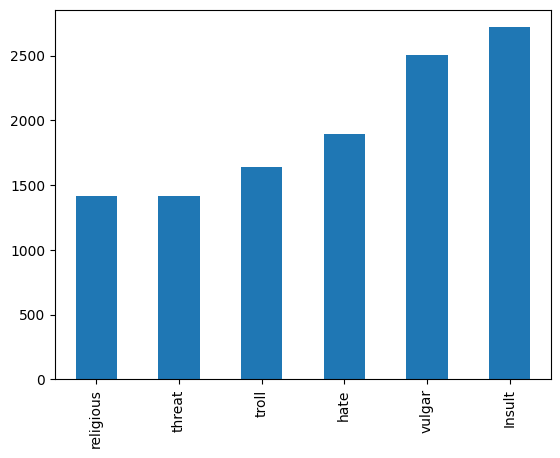

In [8]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="bar");

In [9]:
df[LABEL_COLUMNS].sum()

vulgar       2505
hate         1898
religious    1418
threat       1419
troll        1643
Insult       2719
dtype: int64

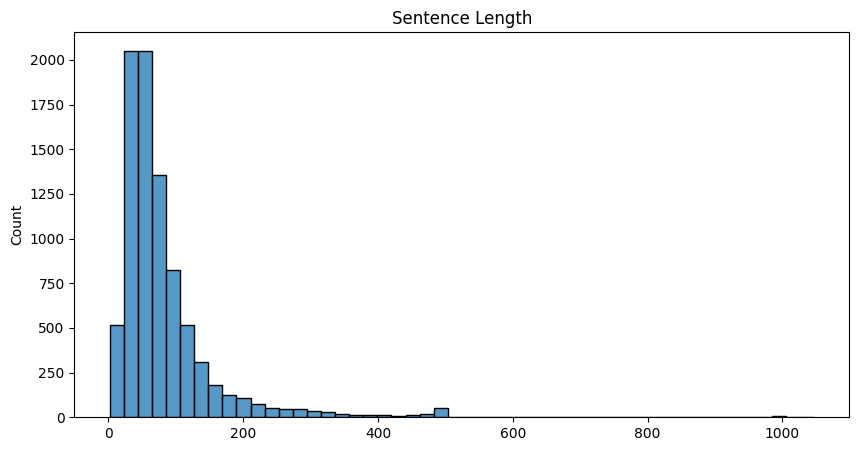

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=50)
plt.title('Sentence Length')
plt.show()

In [11]:
stop_word_list = (stopwords.words('bengali'))

In [12]:
import string

# turn a doc into clean tokens
def clean_doc(doc):
	doc = doc.replace("”","")
	doc = doc.replace("“","")
	# split into tokens by white space
	tokens = doc.split()

	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]

	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if not word.isalpha()]

	# filter out stop words
	#stop_words = stop_word_list
	#tokens = [w for w in tokens if not w in stop_words]

	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

In [13]:
df['text'] = df.text.apply(clean_doc)

In [14]:
sample_row = df.iloc[125]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print(sample_labels.to_dict())

হ্লাপুত তুই দুইটা কি হোগা ম্রা কোটায় পাইছত
{'vulgar': 1, 'hate': 0, 'religious': 0, 'threat': 0, 'troll': 0, 'Insult': 1}


Train Test Split

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [16]:
%%capture
!pip3 install iterative-stratification
!pip install scikit-multilearn

In [17]:
X = df['text']

In [18]:
y = df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
y

vulgar  hate  religious  threat  troll  Insult
0          0     0          0       0      0       1
1          0     0          1       1      0       0
2          0     1          0       0      0       0
3          0     0          1       0      0       0
4          1     0          0       0      0       0
...      ...   ...        ...     ...    ...     ...
8483       1     0          0       0      0       1
8484       1     0          0       0      0       1
8485       0     1          0       0      0       0
8486       0     0          1       0      0       0
8487       0     0          1       0      0       0

[8488 rows x 6 columns]

In [19]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
'''from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.40, random_state=42)
for train_index, test_index in msss.split(X, y):
        x_train, x_test_temp = X[train_index], X[test_index]
        y_train, y_test_temp = y[train_index], y[test_index]'''

In [ ]:
'''msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=42)
for val_index, test_index in msss.split(x_test_temp, y_test_temp):
        x_val, x_test = X[val_index], X[test_index]
        y_val, y_test = y[val_index], y[test_index]'''

In [20]:
train_file = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/x_train", "rb")
val_file = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/x_val", "rb")
test_file = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/x_test", "rb")

#read the file to numpy array
x_train = np.load(train_file, allow_pickle=True)
x_val = np.load(val_file, allow_pickle=True)
x_test = np.load(test_file, allow_pickle=True)

#close the file
train_file.close
val_file.close
test_file.close

<function BufferedReader.close>

In [21]:
# open the file in read binary mode
train_label = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/y_train", "rb")
val_label = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/y_val", "rb")
test_label = open("/content/drive/MyDrive/NLP Project/Dataset/multiclass/y_test", "rb")

#read the file to numpy array
y_train = np.load(train_label, allow_pickle=True)
y_val = np.load(val_label, allow_pickle=True)
y_test = np.load(test_label, allow_pickle=True)

#close the file
train_label.close
val_label.close
test_label.close

<function BufferedReader.close>

In [22]:
train_text = pd.DataFrame(x_train, columns = ['text'])
train_label = pd.DataFrame(y_train, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
train_df = pd.concat([train_text, train_label], axis=1, join='inner')
train_df = train_df.loc[((train_df['vulgar'] == 1) | (train_df['hate'] == 1) | (train_df['religious'] ==1) | (train_df['threat'] == 1) | (train_df['troll'] == 1) | (train_df['Insult'] ==1))]
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

text  vulgar  hate  \
0     কোন মসুলমান যদি রাস্তা দিয়ে যায় আমি বাধ্য মসুল...       1     0   
1     প্রধানমন্ত্রী লোগো সম্বলিত পতাকা ব্যবহার করেন ...       0     1   
2                                 গুয়ার ভিতরে ভইড়া দিমু       1     0   
3        দুইটাই পতিতালয়ে জন্ম নেয়া অবৈধ বেয়াদবের বাচ্চা       1     0   
4     মেয়ে রা জাতির জন্য কাল সাপ ওকে সবাই দরে আগে জু...       0     0   
...                                                 ...     ...   ...   
5088  ভাইজান পায়েলের বুকের কাপর নেই৷ কিন্তু কমরে এতো...       1     0   
5089      পাচা দুধ নামবার তুমার জামা কুলে ফেল সুন্দ হবে       1     0   
5090  আওয়ামীলীগ কর্মীদের একটা প্রব্লেম তাদের বিরুদ্ধ...       0     1   
5091  যে কারণে ঘটনা ঘটছে মাঠে কোনো কোনো ডিসি এসপি ওস...       0     0   
5092  আমার এলাকায় টা রাস্তা খায়ে ফেলেছে আওয়ামী লীগ ন...       0     1   

      religious  threat  troll  Insult  
0             1       0      0       0  
1             0       0      0       0  
2             0       1      0       0  
3             0       0      0       1  
4             0       1      0       1  
...         ...     ...    ...     ...  
5088          0       0      0       0  
5089          0       0      0       0  
5090          0       0      0       0  
5091          0       0      1       0  
5092          0       0      0       0  

[5093 rows x 7 columns]

In [23]:
x_train = train_df['text']
y_train = train_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [24]:
val_text = pd.DataFrame(x_val, columns = ['text'])
val_label = pd.DataFrame(y_val, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
val_df = pd.concat([val_text, val_label], axis=1, join='inner')
val_df = val_df.loc[((val_df['vulgar'] == 1) | (val_df['hate'] == 1) | (val_df['religious'] ==1) | (val_df['threat'] == 1) | (val_df['troll'] == 1) | (val_df['Insult'] ==1))]
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df

text  vulgar  hate  \
0                   শুয়োরের বাচচাটা কবে হবে পেট মোটাতা       1     0   
1     ভারত আমাদের বন্ধু হতে পারেনা আমাদের ১নংবার দুশমন।       0     1   
2                     মইত্তা আলোয় আলোকিত ছাগু সম্প্রদায়       0     0   
3     স্পর্শিয়া সে কি মহিলা নাকি অন্যকিছু আমার এনাফ ...       0     0   
4     আজকে বিল গেটস বাংলাদেশে থাকলে তো ছাড়তোই না গোট...       0     0   
...                                                 ...     ...   ...   
2061        মোল্লাদের বুদ্ধিমত্তা গরুর চেয়ে একটু বেশী।       0     0   
2062  দুই রাউন্ড খেলার মেয়ের অবস্থা ছেলের অবস্থা কার...       1     0   
2063  বিবিসি কি পারবে তালেবানের হাত থেকে আফগানিস্তান...       0     0   
2064  যত্ন করা চুল গুলা ঝরে পড়ে যায় অযত্ন রাখা বাল গ...       0     0   
2065   রানুদির মাথা খারাপ রয়েছে এজন্য ওকে মেনে নিতে হবে       0     0   

      religious  threat  troll  Insult  
0             0       0      0       1  
1             0       0      0       0  
2             0       0      1       0  
3             0       0      0       1  
4             0       0      1       0  
...         ...     ...    ...     ...  
2061          1       0      0       1  
2062          0       0      1       0  
2063          0       0      1       0  
2064          0       0      1       0  
2065          0       0      1       1  

[2066 rows x 7 columns]

In [25]:
x_val = val_df['text']
y_val = val_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()

In [26]:
test_text = pd.DataFrame(x_test, columns = ['text'])
test_label = pd.DataFrame(y_test, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
test_df = pd.concat([test_text, test_label], axis=1, join='inner')
test_df = test_df.loc[((test_df['vulgar'] == 1) | (test_df['hate'] == 1) | (test_df['religious'] ==1) | (test_df['threat'] == 1) | (test_df['troll'] == 1) | (test_df['Insult'] ==1))]
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

text  vulgar  hate  \
0     রানু মুন্ডল কে দেখলে আমার শরীর রক্ত হয়ে যায় তা...       0     0   
1                নিজের পুটকিতে নিজে আঙ্গুল দিয়া বয়া থাক       1     0   
2     তোর ভাগে ভিক্ষার টাকা পাছ নাই তাই হাম্বা হাম্ব...       0     1   
3                      মুচারের পুতেরে শয়তানে লারে চারে।       1     0   
4     রাত দুই টার ফোন দিয়ে বন্ধু তার ২৩৮ ব্রেকআপের ক...       1     0   
...                                                 ...     ...   ...   
1364  দুইদিনেই রাজাকার হয়ে গেলোআমারে আমির বানাইলে দে...       0     1   
1365          প্রিয় সুশীল মনে পড়ে কি ২১ আগস্টের বর্বরতা       0     1   
1366  পোস্ট টা যে করেছে তাকে একটু দেখা দরকার সে কি আ...       1     0   
1367  যাক বঙ্গবন্ধু স্যাটেলাইট সার্থক হলো হজ্বের যাত...       0     0   
1368                         জুতা মারো সবাই সাফা সালিকে       0     0   

      religious  threat  troll  Insult  
0             0       0      0       1  
1             0       0      0       1  
2             0       0      0       0  
3             0       0      0       1  
4             0       0      1       0  
...         ...     ...    ...     ...  
1364          0       0      0       0  
1365          0       0      0       0  
1366          0       1      0       0  
1367          0       0      1       0  
1368          0       1      0       1  

[1369 rows x 7 columns]

In [27]:
x_test = test_df['text']
y_test = test_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [28]:
print("Data ->Vulgar, Hate, Religious, Threat, Troll, Insult")
print("Train: ", y_train.sum(axis = 0))
print("Validation: ", y_val.sum(axis = 0))
print("Test: ", y_test.sum(axis = 0))

Data ->Vulgar, Hate, Religious, Threat, Troll, Insult
Train:  [1503 1139  851  851  986 1631]
Validation:  [624 445 324 343 424 653]
Test:  [440 294 229 224 254 469]


In [29]:
y_test

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1]])

In [30]:
len(x_train), len(x_val), len(x_test)

(5093, 2066, 1369)

In [32]:
pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [33]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

In [34]:
# hyperparameters
max_length = 300
batch_size = 16
#dev_size = 0.2

In [35]:
import tensorflow as tf

In [36]:
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [37]:
X_input_ids_train = np.zeros((len(x_train), max_length))
X_attn_masks_train = np.zeros((len(x_train), max_length))

X_input_ids_dev = np.zeros((len(x_val), max_length))
X_attn_masks_dev = np.zeros((len(x_val), max_length))

X_input_ids_test = np.zeros((len(x_test), max_length))
X_attn_masks_test = np.zeros((len(x_test), max_length))

In [38]:
from tqdm import tqdm
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [39]:
X_input_ids_tain, X_attn_masks_tain = preprocessing_dataset(x_train, X_input_ids_train, X_attn_masks_train, tokenizer)
X_input_ids_dev, X_attn_masks_dev = preprocessing_dataset(x_val, X_input_ids_dev, X_attn_masks_dev, tokenizer)
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(x_test, X_input_ids_test, X_attn_masks_test, tokenizer)

5093it [00:04, 1031.57it/s]
2066it [00:02, 792.25it/s]
1369it [00:01, 1238.92it/s]


In [40]:
X_attn_masks_tain.shape


(5093, 300)

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_tain, X_attn_masks_tain, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_dev, X_attn_masks_dev, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, y_test))

In [42]:
def VulgarDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [43]:
train_dataset = train_dataset.map(VulgarDatasetMapFunction)
dev_dataset = dev_dataset.map(VulgarDatasetMapFunction)
test_dataset = test_dataset.map(VulgarDatasetMapFunction)

In [44]:
train_dataset = train_dataset.shuffle(100).batch(batch_size)
dev_dataset = dev_dataset.shuffle(100).batch(batch_size)
test_dataset = test_dataset.shuffle(100).batch(batch_size)

Actual one(previous)

In [45]:
import tensorflow as tf
from keras.optimizers import adam_v2
'''from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential'''
from tensorflow.keras.optimizers import Adam

ImportError: cannot import name 'adam_v2' from 'keras.optimizers' (/usr/local/lib/python3.10/dist-packages/keras/optimizers/__init__.py)

new

In [46]:
import tensorflow as tf
#from keras.optimizers import adam_v2
'''from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential'''
from tensorflow.keras.optimizers import Adam

previous

In [47]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import CuDNNLSTM

ImportError: cannot import name 'CuDNNLSTM' from 'keras.layers' (/usr/local/lib/python3.10/dist-packages/keras/layers/__init__.py)

new

In [48]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
#from keras.layers import CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [49]:
import keras
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from pickle import load

from keras.layers import Conv1D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed

In [50]:
#Import necessary libraries
# demonstration of calculating metrics for a neural network model using sklearn
import keras.backend as K
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.metrics import Metric


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [51]:
from keras import initializers as initializers, regularizers, constraints
REG_PARAM = 1e-13
#l2_reg = regularizers.l2(REG_PARAM)

In [52]:
import tensorflow as tf
from transformers import TFBertModel

In [53]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attn_masks = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    encoder_embedding_layer = bert_encoder(input_word_ids, attention_mask=attn_masks)[0]

    conv1D_1 = tf.keras.layers.Conv1D(512, 4, activation='relu',name='con1')(encoder_embedding_layer)
    maxPool1D_1 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool1')(conv1D_1)

    conv1D_2 = tf.keras.layers.Conv1D(256, 3, activation='relu',name='con2')(maxPool1D_1)
    maxPool1D_2 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool2')(conv1D_2)

    conv1D_3 = tf.keras.layers.Conv1D(128, 2, activation='relu',name='con3')(maxPool1D_2)
    maxPool1D_3 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool3')(conv1D_3)

    '''
    # Apply Bidirectional LSTM over embedded inputs
    lstm_outs = keras.layers.wrappers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True)
    )(maxPool1D_3)

    '''
    # Apply Bidirectional LSTM over embedded inputs
    lstm_outs = Bidirectional(keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(REG_PARAM)))(maxPool1D_3)



    # Attention Mechanism - Generate attention vectors
    #attention_output = AttentionLayer(lstm_outs)
    input_dim = int(lstm_outs.shape[2])
    permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
    attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
    #print(attention_vector.shape)
    attention_vector = keras.layers.Reshape((attention_vector.shape[1],))(attention_vector)
    attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
    #attention_vector = keras.layers.Activation('relu', name='attention_vec')(attention_vector)
    #attention_vector = keras.layers.Activation('tanh', name='attention_vec')(attention_vector)
    attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

    # Last layer: fully connected with softmax activation
    fc = keras.layers.Dense(64, activation='relu')(attention_output)
    output = keras.layers.Dense(6, activation='sigmoid')(fc)

    # Finally building model
    model = keras.Model(inputs=[input_word_ids, attn_masks], outputs=output)


    return model

In [54]:
model = bert_model()

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [55]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              #optimizer=tf.keras.optimizers.Adam(1e-5),
              optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
              metrics=['accuracy', fmeasure, precision, recall])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 300)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1643965   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 300, 7                                       

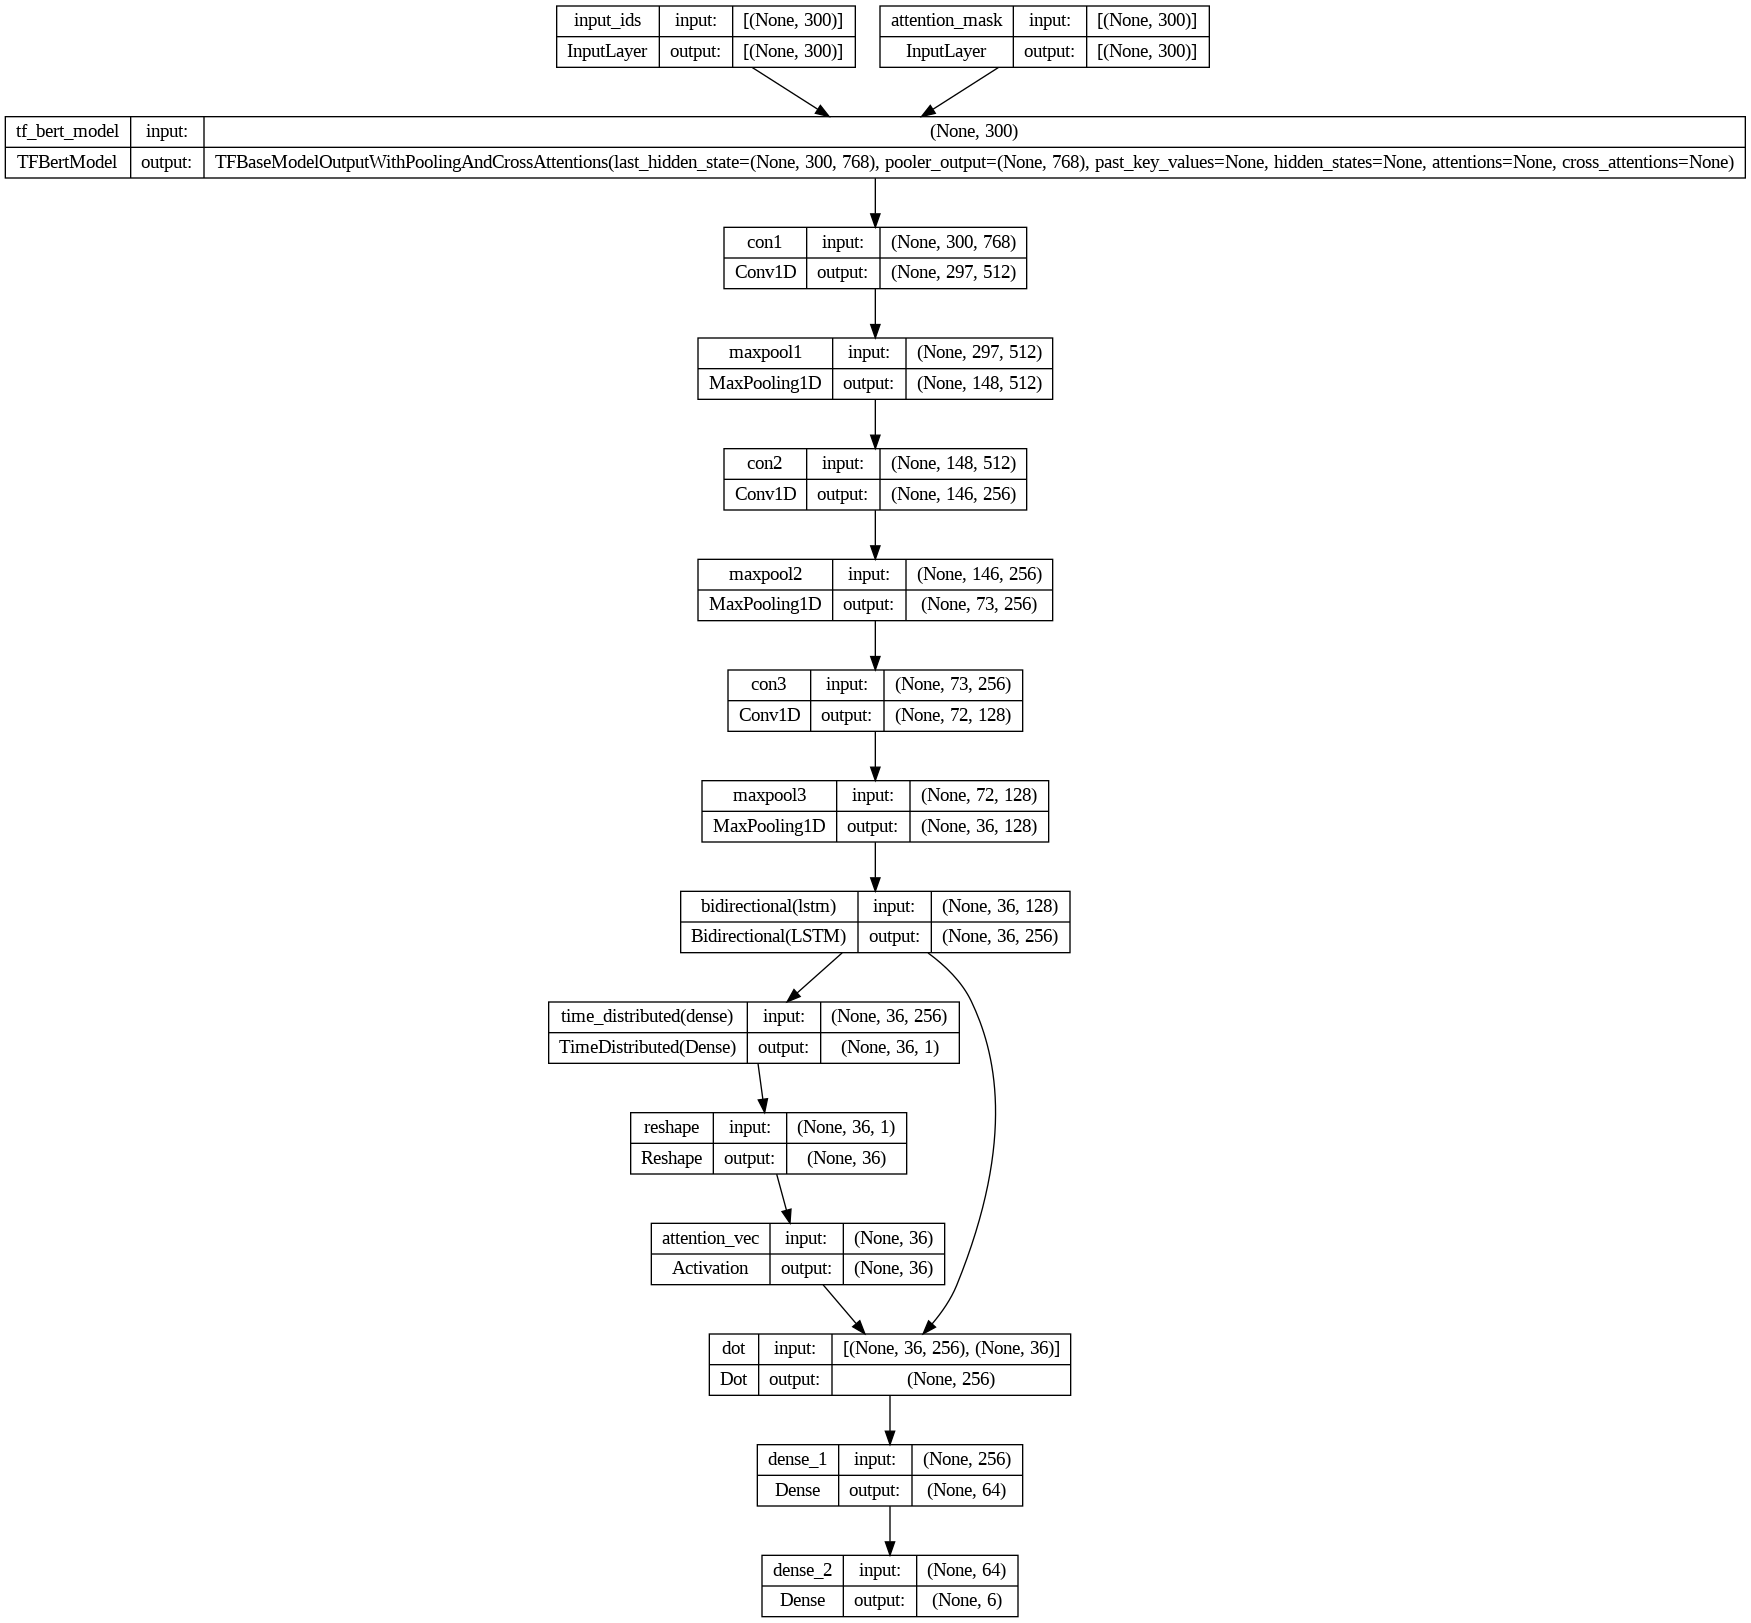

In [56]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [57]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
'''
#checkpoint which stores the weights of the model when maximum validation accuracy is found
checkpoint_filepath = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    batch_size=32,
    epochs=9,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1,
    callbacks=[checkpoint])
'''

In [58]:
#model1 = model
history = model.fit(
    train_dataset,
    batch_size=16,
    epochs=8,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1)

Epoch 1/8
319/319 [==============================] - 397s 1s/step - loss: 0.4851 - accuracy: 0.3039 - fmeasure: 0.2546 - precision: 0.5115 - recall: 0.1862 - val_loss: 0.3975 - val_accuracy: 0.5625 - val_fmeasure: 0.5607 - val_precision: 0.7099 - val_recall: 0.4718
Epoch 2/8
319/319 [==============================] - 361s 1s/step - loss: 0.3665 - accuracy: 0.6036 - fmeasure: 0.6085 - precision: 0.7549 - recall: 0.5195 - val_loss: 0.3203 - val_accuracy: 0.6781 - val_fmeasure: 0.7024 - val_precision: 0.7609 - val_recall: 0.6575
Epoch 3/8
319/319 [==============================] - 360s 1s/step - loss: 0.3014 - accuracy: 0.6978 - fmeasure: 0.7226 - precision: 0.8023 - recall: 0.6633 - val_loss: 0.2936 - val_accuracy: 0.7312 - val_fmeasure: 0.7258 - val_precision: 0.7814 - val_recall: 0.6802
Epoch 4/8
319/319 [==============================] - 357s 1s/step - loss: 0.2485 - accuracy: 0.7630 - fmeasure: 0.7911 - precision: 0.8461 - recall: 0.7483 - val_loss: 0.2556 - val_accuracy: 0.7563 - va

In [59]:
test_score = model.evaluate(test_dataset)

print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

86/86 [==============================] - 33s 377ms/step - loss: 0.1973 - accuracy: 0.7772 - fmeasure: 0.8481 - precision: 0.8818 - recall: 0.8203
Test Loss: 0.19729667901992798
Test Accuracy: 0.7772096395492554


In [60]:
y_pred = model.predict([X_input_ids_test, X_attn_masks_test])

43/43 [==============================] - 37s 709ms/step


In [61]:
len(y_test), len(y_pred)

(1369, 1369)

In [62]:
Threshold = 0.5
upper, lower = 1, 0

In [63]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
y_pred1 = y_pred
y_true = y_test



y_pred1 = np.where(y_pred >= .5, upper, lower)

print(classification_report(
  y_true,
  y_pred1,
  digits = 4,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

              precision    recall  f1-score   support

      vulgar     0.9271    0.8955    0.9110       440
        hate     0.8462    0.8605    0.8533       294
   religious     0.8983    0.9258    0.9118       229
      threat     0.8458    0.7589    0.8000       224
       troll     0.8469    0.6969    0.7646       254
      Insult     0.8878    0.7591    0.8184       469

   micro avg     0.8820    0.8178    0.8487      1910
   macro avg     0.8753    0.8161    0.8432      1910
weighted avg     0.8813    0.8178    0.8470      1910
 samples avg     0.8598    0.8301    0.8348      1910



In [64]:
from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)
print(conf_mat)

[[[ 898   31]
  [  46  394]]

 [[1029   46]
  [  41  253]]

 [[1116   24]
  [  17  212]]

 [[1114   31]
  [  54  170]]

 [[1083   32]
  [  77  177]]

 [[ 855   45]
  [ 113  356]]]


In [65]:
conf_mat[5]

array([[855,  45],
       [113, 356]])

In [66]:
def multilabel_accuracies(p):
    TP = p[1][1]
    TN = p[0][0]
    FP = p[0][1]
    FN = p[1][0]
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(acc)

In [67]:
confusion_matrix_vulgar = multilabel_confusion_matrix(y_test, y_pred1)[0]
print(confusion_matrix_vulgar)

[[898  31]
 [ 46 394]]


Each label accuracy: 
vulgar
0.943754565376187
hate
0.9364499634769905
religious
0.9700511322132944
threat
0.9379108838568299
troll
0.9203798392987582
Insult
0.8845872899926954


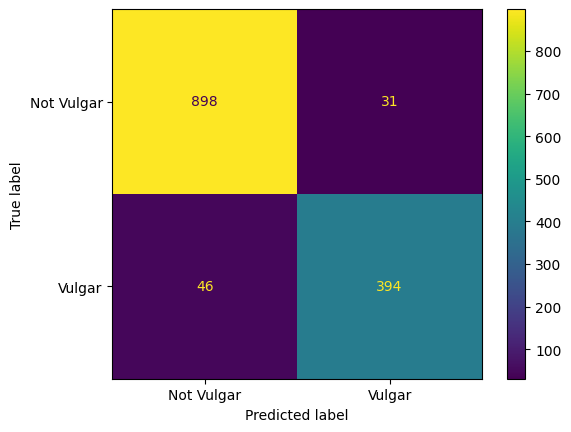

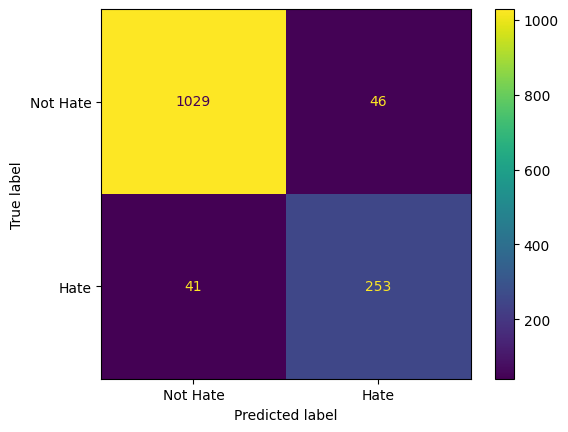

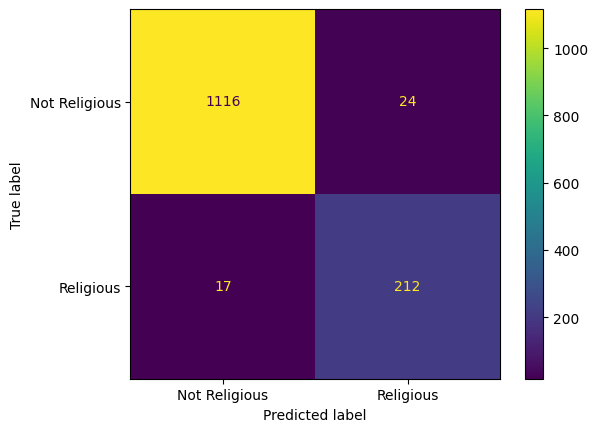

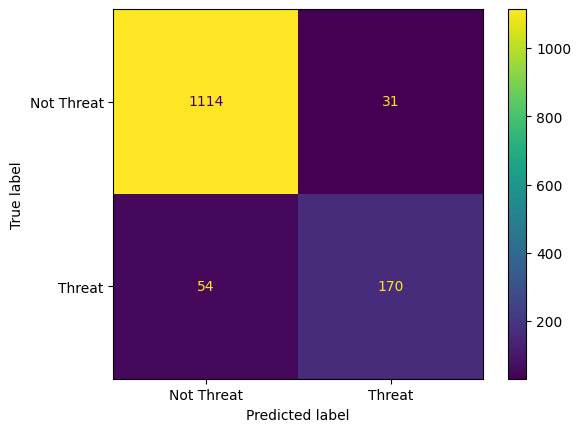

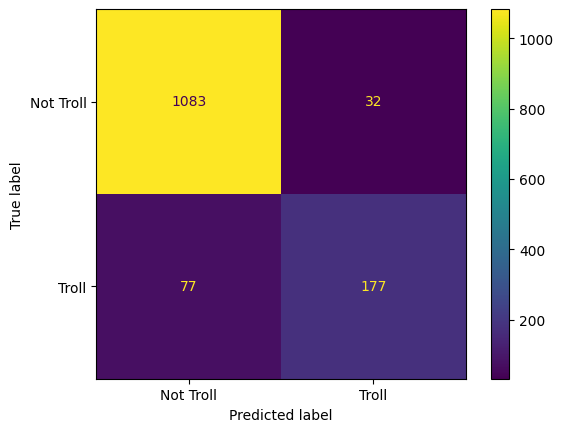

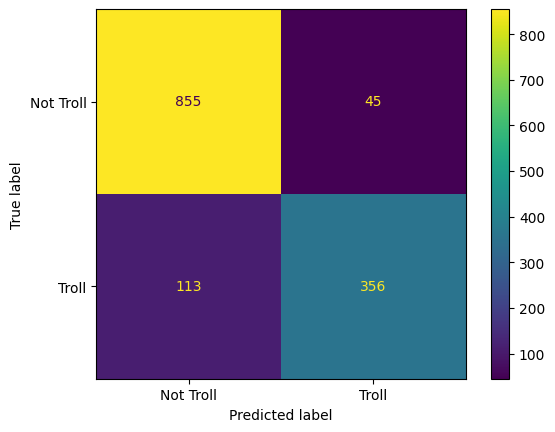

In [68]:
y_pred1 = np.where(y_pred >= .5, upper, lower)


from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)


print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

vulgar = conf_mat[0]
hate = conf_mat[1]
religious = conf_mat[2]
threat = conf_mat[3]
troll = conf_mat[4]
insult = conf_mat[5]


cm_vulgar = metrics.ConfusionMatrixDisplay(confusion_matrix = vulgar, display_labels = ['Not Vulgar', 'Vulgar'])
cm_hate = metrics.ConfusionMatrixDisplay(confusion_matrix = hate, display_labels = ['Not Hate', 'Hate'])
cm_religious = metrics.ConfusionMatrixDisplay(confusion_matrix = religious, display_labels = ['Not Religious', 'Religious'])
cm_threat = metrics.ConfusionMatrixDisplay(confusion_matrix = threat, display_labels = ['Not Threat', 'Threat'])
cm_troll = metrics.ConfusionMatrixDisplay(confusion_matrix = troll, display_labels = ['Not Troll', 'Troll'])
cm_insult = metrics.ConfusionMatrixDisplay(confusion_matrix = insult, display_labels = ['Not Troll', 'Troll'])

cm_vulgar.plot()
cm_hate.plot()
cm_religious.plot()
cm_threat.plot()
cm_troll.plot()
cm_insult.plot()

plt.show()

In [69]:
print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

Each label accuracy: 
vulgar
0.943754565376187
hate
0.9364499634769905
religious
0.9700511322132944
threat
0.9379108838568299
troll
0.9203798392987582
Insult
0.8845872899926954


In [70]:
vulgar = conf_mat[0]
hate = conf_mat[1]
religious = conf_mat[2]
threat = conf_mat[3]
troll = conf_mat[4]
insult = conf_mat[5]

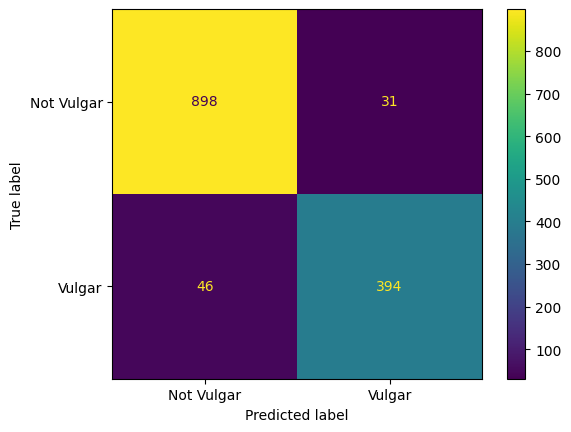

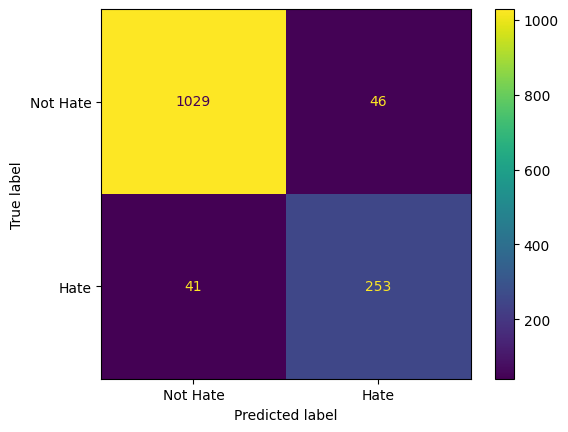

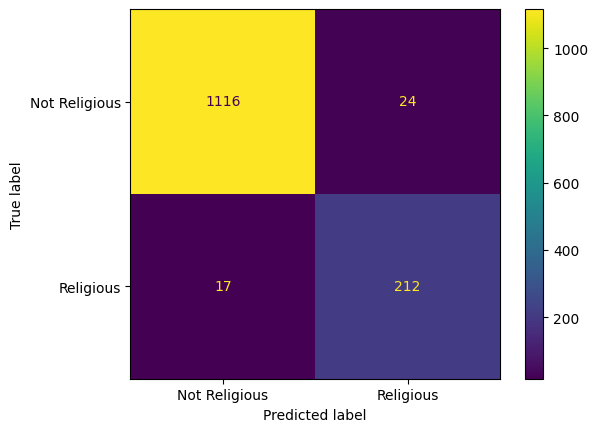

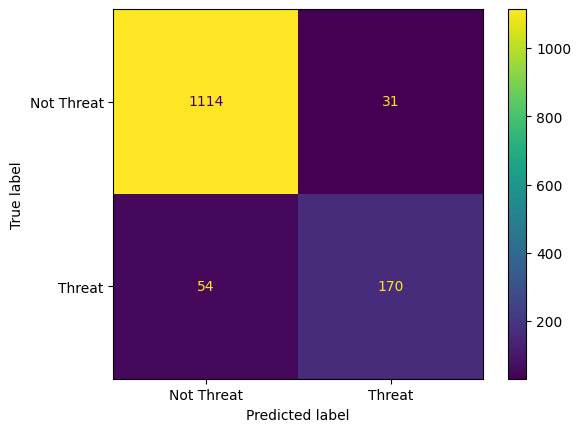

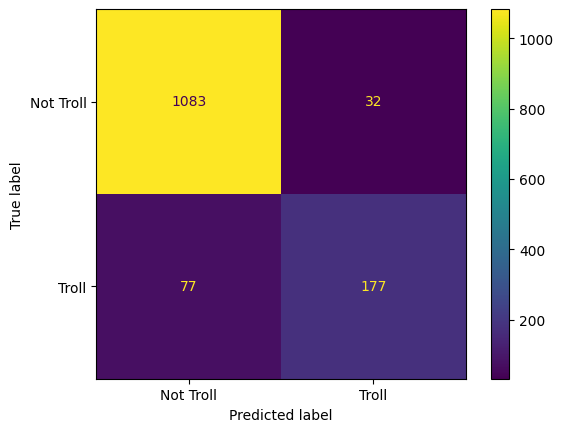

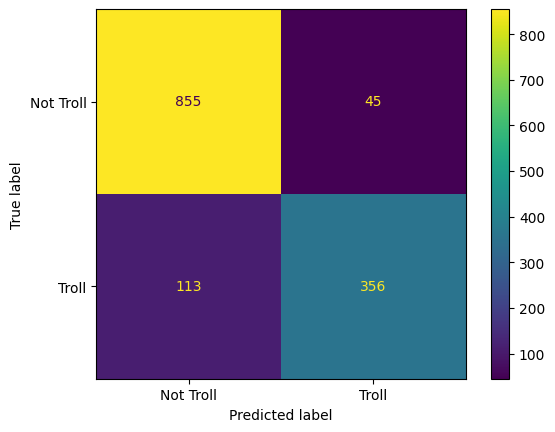

In [71]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_vulgar = metrics.ConfusionMatrixDisplay(confusion_matrix = vulgar, display_labels = ['Not Vulgar', 'Vulgar'])
cm_hate = metrics.ConfusionMatrixDisplay(confusion_matrix = hate, display_labels = ['Not Hate', 'Hate'])
cm_religious = metrics.ConfusionMatrixDisplay(confusion_matrix = religious, display_labels = ['Not Religious', 'Religious'])
cm_threat = metrics.ConfusionMatrixDisplay(confusion_matrix = threat, display_labels = ['Not Threat', 'Threat'])
cm_troll = metrics.ConfusionMatrixDisplay(confusion_matrix = troll, display_labels = ['Not Troll', 'Troll'])
cm_insult = metrics.ConfusionMatrixDisplay(confusion_matrix = insult, display_labels = ['Not Troll', 'Troll'])

cm_vulgar.plot()
cm_hate.plot()
cm_religious.plot()
cm_threat.plot()
cm_troll.plot()
cm_insult.plot()

plt.show()

In [72]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.5035062003880739)

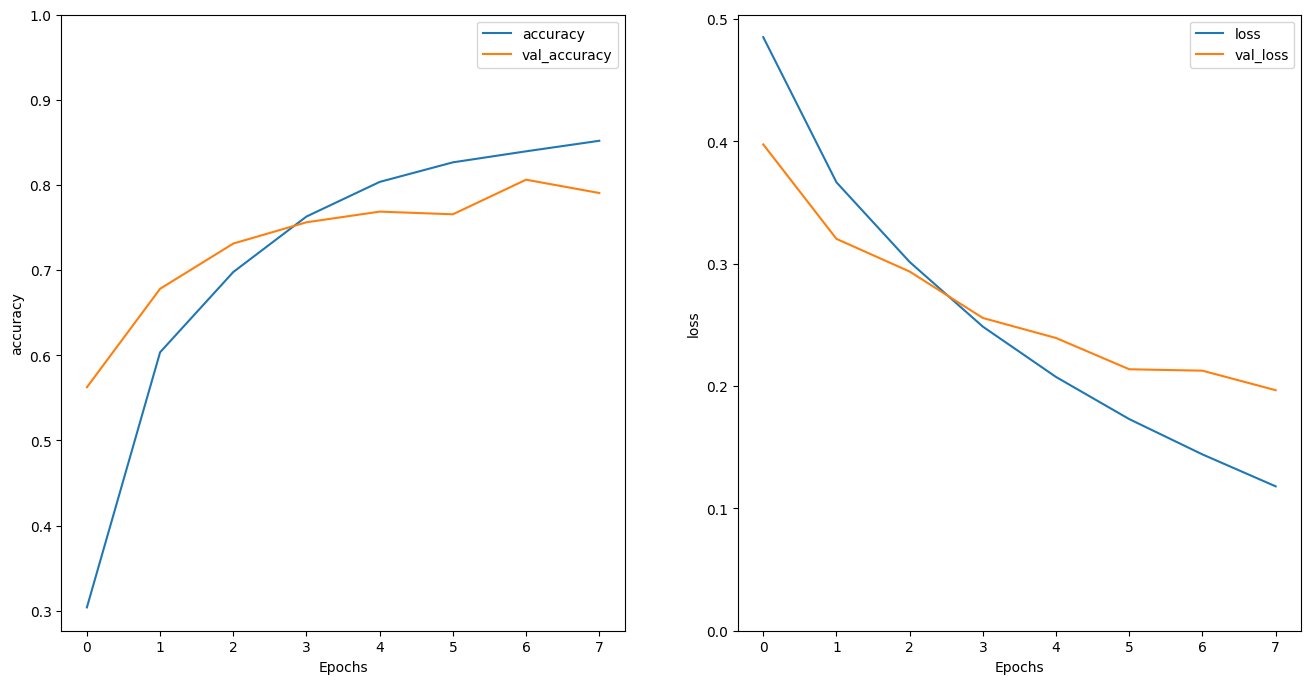

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [76]:
model.save_weights("/content/drive/MyDrive/save model")

In [77]:
model1 = model

In [78]:
model1.load_weights("/content/drive/MyDrive/save model")

In [79]:
LABEL_COLUMNS

['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']

Predict New sentence

In [80]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('ভারত রেন্ডিমাগি পাকিস্তান খাংকীমাগির পুত। মরুক দুই বানচোত।')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model1, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 7s 7s/step
Classification results: [1 0 0 0 0 1]


In [81]:
%%capture
!pip3 install lime

In [82]:
from lime.lime_text import LimeTextExplainer
class_names=['vulgar', 'hate', 'religious', 'threat', 'troll', 'insult']
explainer= LimeTextExplainer(class_names=class_names, split_expression=' ')

def predict_proba(arr):
    total_preds=[]
    for i in arr:
        tokens = prepare_data(i, tokenizer)
        preds = model1.predict(tokens)[0]
        total_preds.append(preds)

    returnable = []
    for i in total_preds:
        temp = i
        returnable.append(np.array(temp))

    return np.array(returnable)

In [83]:
%%capture
sentence = clean_doc('কি হিংসে হয়')
exp = explainer.explain_instance(sentence, predict_proba, num_features=10, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

In [84]:
print('Text: কি হিংসে হয়')
exp.show_in_notebook(text=True, show_predicted_value=True, predict_proba=True)

Text: কি হিংসে হয়


In [85]:
print('Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
sentence = clean_doc('মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
exp = explainer.explain_instance(sentence, predict_proba, num_features=40, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??
1/1 [==============================] - 0s 77ms/step


In [86]:
print('Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
exp.show_in_notebook(text=True)

Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??


In [87]:
sentence = 'ধর্ম নিয়ে ব্যবসা'
exp = explainer.explain_instance(sentence, predict_proba, num_features=40, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

1/1 [==============================] - 0s 164ms/step


In [88]:
exp.show_in_notebook(text=True)

In [89]:
exp_label = exp.available_labels()

for i in exp_label:
    print(LABEL_COLUMNS[i], " ",exp.as_list(label=i), end="\n\n")

vulgar   [('ধর্ম', -0.387628882053734), ('নিয়ে', -0.28178385729653344), ('ব্যবসা', -0.11784073810485868)]

hate   [('ব্যবসা', -0.05173188219130766), ('ধর্ম', -0.049230210584066576), ('নিয়ে', -0.004738663989410949)]

religious   [('ধর্ম', 0.888357925065296), ('ব্যবসা', -0.03379920294836608), ('নিয়ে', -0.026738001928394504)]

threat   [('নিয়ে', 0.04448033173376278), ('ব্যবসা', 0.04333962016288172), ('ধর্ম', -0.0351447341387725)]

troll   [('ধর্ম', -0.22163975107718378), ('নিয়ে', 0.05196796330308297), ('ব্যবসা', -0.016872195835321638)]

Insult   [('ধর্ম', 0.023824081715999552), ('নিয়ে', -0.017126796151672098), ('ব্যবসা', 0.00728788488221134)]



In [90]:
exp.predict_proba

array([0.01783443, 0.03851976, 0.9668684 , 0.01578531, 0.02190552,
       0.0408163 ], dtype=float32)

In [91]:
#%% ROC-AUC Curve

#y_score = cv_model.predict_proba(X_test)
y_score = model.predict([X_input_ids_test, X_attn_masks_test])

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 6 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

43/43 [==============================] - 31s 726ms/step


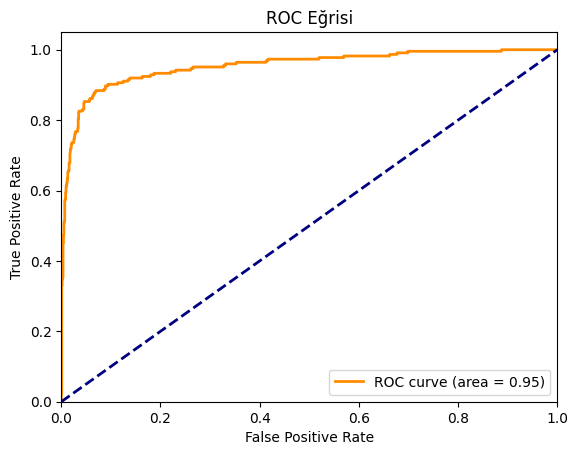

In [92]:
# The process of drawing a roc-auc curve belonging to a specific class

plt.figure()
lw = 2 # line_width
plt.plot(fpr[3], tpr[3], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3]) # Drawing Curve according to 3. class
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

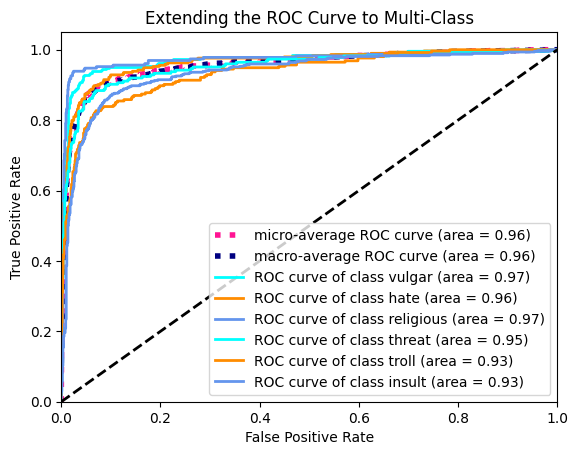

In [93]:
class_names=['vulgar', 'hate', 'religious', 'threat', 'troll', 'insult']
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

k = 0
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ class_names[k] + ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    k = k+1

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()